# Python-Data-2A-ENSAE

We present here the main results of our work.

## Data analysis

First, we analyse our data, starting with our MNIST data.

In [1]:
from MNIST import MnistDataloader, show_images

mnist = MnistDataloader(data_dir="..\\data\\MNIST")
show_images(show_noisy=False, rseed=21)

c:\Users\yanno\OneDrive\Documents\GitHub\Python-Data-2A-ENSAE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'show_images' from 'MNIST' (c:\Users\yanno\OneDrive\Documents\GitHub\Python-Data-2A-ENSAE\src\MNIST.py)

Chargement des données avec bruit (gaussian, facteur: 0.5)...


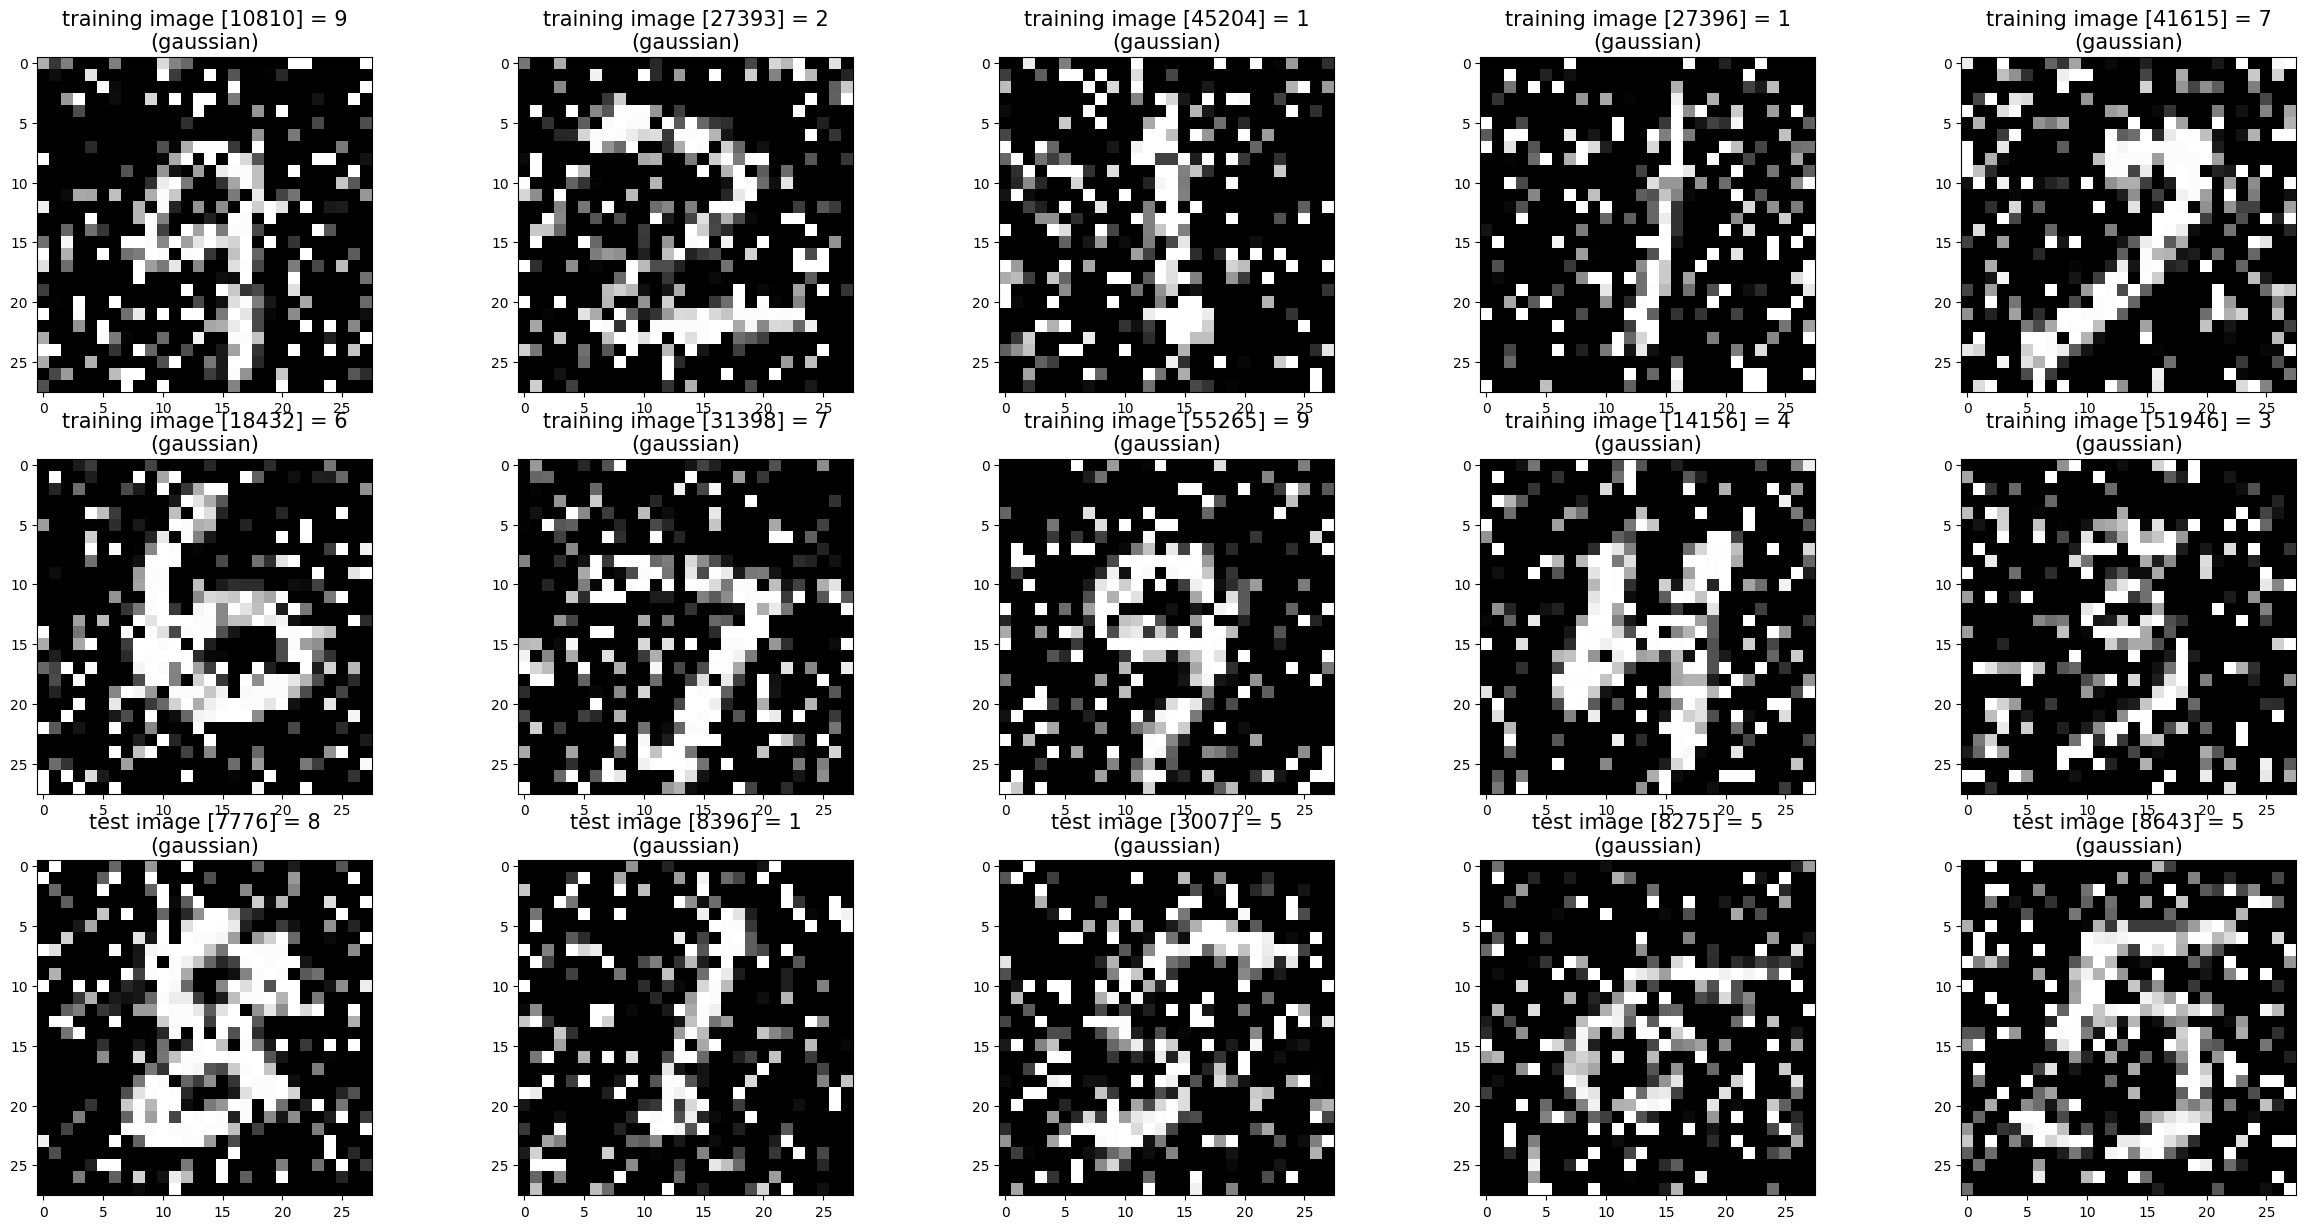

: 

In [ ]:
show_images(show_noisy=True, noise_type="gaussian", noise_factor=0.5, rseed=21)

Chargement des données avec bruit (salt_and_pepper, facteur: 0.5)...


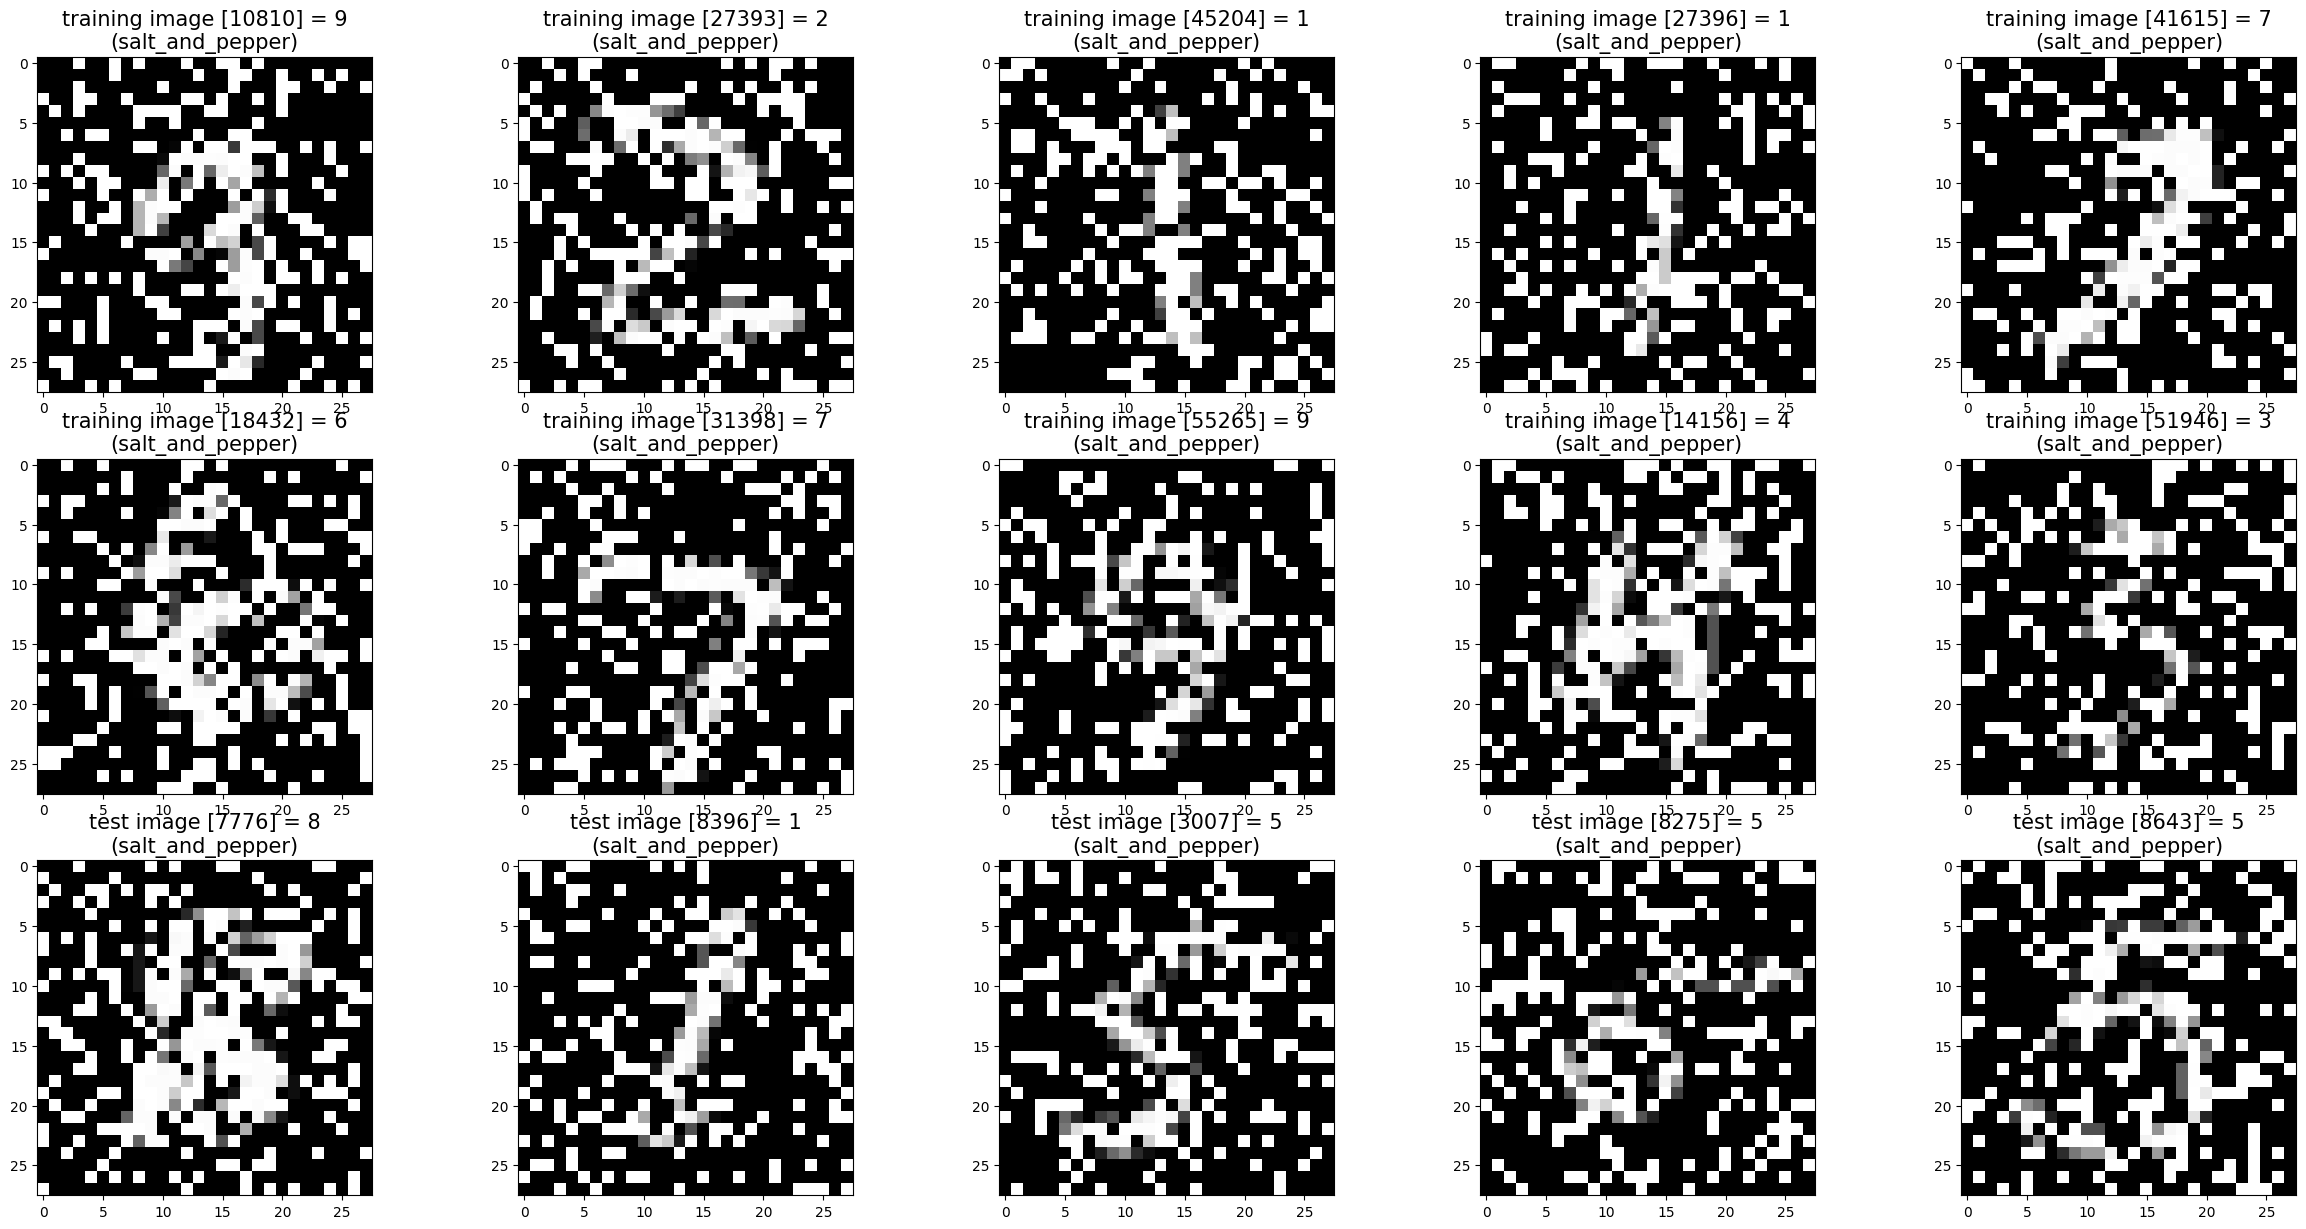

: 

In [ ]:
show_images(show_noisy=True, noise_type="salt_and_pepper", noise_factor=0.5, rseed=21)

We generate a csv file containing the following features : 
 - id: the identifier of the captcha image data
 - image format: (0: grayscale; 1: rgb)
 - solution: the solution of the captcha image
 - noise: (0: no noise; 1: noisy image)
 - noise_type: the type of noise used on the image ("none", "salt_and_pepper", "gaussian")
 - noise_factor: the percentage of pixels on witch the noise has been applied
 - response of the model: the solution of the captcha image given by the model

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from MNIST import MnistDataloader
from multi_head_CNN import apply_balanced_noise
import os

# Load CAPTCHA dataset
data_dir = '..\data'
mnist_loader = MnistDataloader(data_dir=data_dir)
h5_filepath = os.path.join(data_dir, 'captcha_data', 'captcha_dataset.h5')
(x_train, y_train), (x_test, y_test) = mnist_loader.load_captcha_dataset(h5_filepath=h5_filepath, num_images_test=100)
# Limit to 100 test images for demo

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\yanno\AppData\Local\Temp\ipykernel_13504\1837168526.py:9: SyntaxWarning: invalid escape sequence '\d'
  data_dir = '..\data'


Loading all training data (100000 images)...
Loading 100 test images (sequential)...
Loading 100 test images (sequential)...
CAPTCHA dataset loaded successfully!
CAPTCHA dataset loaded successfully!


In [6]:
# Load the model
model_path = '..\data/models/multi_output_cnn.keras'
model = tf.keras.models.load_model(model_path)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\yanno\AppData\Local\Temp\ipykernel_13504\317720995.py:2: SyntaxWarning: invalid escape sequence '\d'
  model_path = '..\data/models/multi_output_cnn.keras'


In [ ]:
# Noise configurations are now generated dynamically in the loop using apply_balanced_noise from multi_head_CNN
# This provides a uniform distribution of noise_factor from 0.3 to 1.0 with step 0.1 for each noise type

In [7]:
# Prepare data for CSV
data_rows = []

for idx, (image, true_solution) in enumerate(zip(x_test, y_test)):
    # Determine image format
    if len(image.shape) == 3 and image.shape[-1] == 1:  # Grayscale
        image_format = 0
        image_data = image.astype(int)  # numpy array of ints 0-255
    elif len(image.shape) == 3 and image.shape[-1] == 3:  # RGB
        image_format = 1
        image_data = image.astype(int)  # 3D array (H, W, C)
    else:
        continue  # Skip if not matching
    
    solution = ''.join(map(str, true_solution))  # Convert list to string
    
    # First, add the no-noise case
    noisy_image = image
    # Preprocess for model
    if image_format == 0:  # Grayscale
        image_gray = noisy_image
    else:  # RGB
        image_gray = np.mean(noisy_image, axis=-1, keepdims=True)
    image_normalized = image_gray.astype('float32') / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)
    
    # Predict
    predictions = model.predict(image_batch, verbose=0)
    predicted_digits = [int(np.argmax(pred[0])) for pred in predictions]
    response = ''.join(map(str, predicted_digits))
    
    # Add row for no noise
    data_rows.append({
        'id': idx,
        'image_format': image_format,
        'image_data': image_data,  # numpy array
        'solution': solution,
        'noise': 0,
        'noise_type': 'none',
        'noise_factor': 0.0,
        'response': response
    })
    
    # Now, for each noise type, generate balanced noise from 0.3 to 1.0
    for noise_type in ['gaussian', 'salt_and_pepper']:
        # Generate noise levels uniformly from 0.3 to 1.0 with step 0.1
        noise_levels = []
        current = 0.3
        while current <= 1.0 + 1e-9:
            noise_levels.append(round(current, 5))
            current += 0.1
        num_levels = len(noise_levels)
        
        # Repeat the image num_levels times
        images_batch = [image] * num_levels
        
        # Apply balanced noise using the function from multi_head_CNN
        noisy_images = apply_balanced_noise(images_batch, noise_type, 0.3, 1.0, 0.1, rgb_noise=(image_format == 1))
        
        # For each noisy image and corresponding level
        for noisy_image, level in zip(noisy_images, noise_levels):
            # Preprocess for model
            if image_format == 0:  # Grayscale
                image_gray = noisy_image
            else:  # RGB
                image_gray = np.mean(noisy_image, axis=-1, keepdims=True)
            image_normalized = image_gray.astype('float32') / 255.0
            image_batch = np.expand_dims(image_normalized, axis=0)
            
            # Predict
            predictions = model.predict(image_batch, verbose=0)
            predicted_digits = [int(np.argmax(pred[0])) for pred in predictions]
            response = ''.join(map(str, predicted_digits))
            
            # Add row
            data_rows.append({
                'id': idx,
                'image_format': image_format,
                'image_data': image_data,  # numpy array
                'solution': solution,
                'noise': 1,
                'noise_type': noise_type,
                'noise_factor': level,
                'response': response
            })

Applying gaussian noise with 8 levels: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Level 0.30: processing 1 images (1-1)
  Level 0.40: processing 1 images (2-2)
  Level 0.50: processing 1 images (3-3)
  Level 0.60: processing 1 images (4-4)
  Level 0.70: processing 1 images (5-5)
  Level 0.80: processing 1 images (6-6)
  Level 0.90: processing 1 images (7-7)
  Level 1.00: processing 1 images (8-8)
Applying salt_and_pepper noise with 8 levels: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Level 0.30: processing 1 images (1-1)
  Level 0.40: processing 1 images (2-2)
  Level 0.50: processing 1 images (3-3)
  Level 0.60: processing 1 images (4-4)
  Level 0.70: processing 1 images (5-5)
  Level 0.80: processing 1 images (6-6)
  Level 0.90: processing 1 images (7-7)
  Level 1.00: processing 1 images (8-8)
Applying salt_and_pepper noise with 8 levels: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Level 0.30: processing 1 images (1-1)
  Level 0.40: processing 1 images (2-2)
  Level 0.50: processing 1

In [ ]:
# Create DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (note: numpy arrays will be stored as strings; for full arrays, consider HDF5 or pickle)

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\yanno\AppData\Local\Temp\ipykernel_13504\1995847081.py:5: SyntaxWarning: invalid escape sequence '\c'
  df.to_csv('data\captcha_evaluation.csv', index=False)


CSV file 'captcha_evaluation.csv' created successfully.


 We will then be able to perform regressions of the precision of the model on the following features : noise_type and noise_factor. The precision of the model is the sum of 1_[good response] / Card(evaluated data)

## Statistiques descriptives

Nous allons analyser comment différents types de bruit (gaussien, salt & pepper) et différents niveaux de bruit influencent la capacité du modèle CNN à résoudre les captchas.

### Plan d'analyse :
1. **Distribution des variables** : Examiner la distribution des variables explicatives (noise_type, noise_factor, image_format)
2. **Statistiques univariées** : Calculer les statistiques de base pour chaque variable
3. **Corrélations** : Analyser les relations entre les variables explicatives
4. **Analyse par groupe** : Comparer les performances du modèle selon le type de bruit et le niveau de bruit

In [ ]:
# Import des bibliothèques nécessaires pour l'analyse statistique
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Exemple de génération de données simulées pour illustration
np.random.seed(42)
n_samples = 1000

sol = [np.random.randint(0, 10, 4) for _ in range(n_samples)]
noise_factors = np.random.choice([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], n_samples)
# Simuler des données d'exemple
data = {
    'id': range(n_samples),
    'image_format': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),  # 0: grayscale, 1: RGB
    'solution': sol,
    'noise': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),  # 0: no noise, 1: noisy
    'noise_type': np.random.choice(['none', 'gaussian', 'salt_and_pepper'], n_samples, p=[0.3, 0.35, 0.35]),
    'noise_factor': noise_factors,
    'model_response': [[sol[i][j] if np.random.rand() > 0.2+0.5*noise_factors[i] else np.random.randint(0, 10) for j in range(4)] for i in range(n_samples)],
    'OCR_response': [[sol[i][j] if np.random.rand() > 0.4+0.4*noise_factors[i] else np.random.randint(0, 10) for j in range(4)] for i in range(n_samples)],
}

df = pd.DataFrame(data)
# Calculer si la prédiction est correcte
df['correct'] = df.apply(
    lambda row: int(all(a == b for a, b in zip(row['solution'], row['model_response']))),
    axis=1
)
# Calculer le nombre de chiffres corrects pour chaque prédiction
df['n_correct_digits'] = df.apply(
    lambda row: sum(1 for a, b in zip(row['solution'], row['model_response']) if a == b), 
    axis=1
)

#On regarde chaque digit indépendamment
for digit_pos in range(4):
    df[f'correct_digit_{digit_pos}'] = df.apply(
        lambda row: int(row['solution'][digit_pos] == row['model_response'][digit_pos]),
        axis=1
    )

print("Aperçu des données (simulées) :")
print(df.head(10))
print(f"\nDimensions du dataset : {df.shape}")
print(f"\nTypes de variables :\n{df.dtypes}")

Aperçu des données (simulées) :
   id  image_format      solution  noise       noise_type  noise_factor  \
0   0             1  [6, 3, 7, 4]      1             none           0.1   
1   1             1  [6, 9, 2, 6]      1             none           0.3   
2   2             1  [7, 4, 3, 7]      0  salt_and_pepper           0.2   
3   3             1  [7, 2, 5, 4]      1         gaussian           0.4   
4   4             0  [1, 7, 5, 1]      0         gaussian           0.3   
5   5             0  [4, 0, 9, 5]      1             none           0.1   
6   6             0  [8, 0, 9, 2]      1  salt_and_pepper           0.1   
7   7             1  [6, 3, 8, 2]      1  salt_and_pepper           0.5   
8   8             1  [4, 2, 6, 4]      1  salt_and_pepper           0.2   
9   9             1  [8, 6, 1, 3]      1         gaussian           0.1   

  model_response  correct  n_correct_digits  correct_digit_0  correct_digit_1  \
0   [9, 3, 7, 4]        0                 3                0 

In [28]:
### 1. Statistiques descriptives univariées

print("=" * 80)
print("STATISTIQUES DESCRIPTIVES UNIVARIÉES")
print("=" * 80)

# Variable à expliquer : taux de succès
print("\n1. VARIABLE À EXPLIQUER : Précision du modèle")
print("-" * 80)
accuracy_overall = df['correct'].mean()
print(f"Précision globale du modèle : {accuracy_overall:.2%}")
print(f"Nombre total de prédictions : {len(df)}")
print(f"Nombre de prédictions correctes : {df['correct'].sum()}")
print(f"Nombre de prédictions incorrectes : {(1 - df['correct']).sum()}")

# Distribution du nombre de chiffres corrects par captcha
print(f"\nDistribution du nombre de chiffres corrects (sur 4) :")
print(df['n_correct_digits'].value_counts().sort_index())
print(f"\nMoyenne de chiffres corrects : {df['n_correct_digits'].mean():.2f}/4")
print(f"Écart-type : {df['n_correct_digits'].std():.2f}")

# Variables explicatives
print("\n\n2. VARIABLES EXPLICATIVES")
print("-" * 80)

# Type de bruit
print("\nDistribution du type de bruit :")
print(df['noise_type'].value_counts())
print(f"\nProportions :")
print(df['noise_type'].value_counts(normalize=True).round(3))

# Niveau de bruit
print("\n\nDistribution du facteur de bruit :")
print(df['noise_factor'].value_counts().sort_index())
print(f"\nStatistiques sur noise_factor :")
print(df['noise_factor'].describe())

# Format d'image
print("\n\nDistribution du format d'image :")
image_format_labels = {0: 'Grayscale', 1: 'RGB'}
print(df['image_format'].map(image_format_labels).value_counts())
print(f"\nProportions :")
print(df['image_format'].map(image_format_labels).value_counts(normalize=True).round(3))

STATISTIQUES DESCRIPTIVES UNIVARIÉES

1. VARIABLE À EXPLIQUER : Précision du modèle
--------------------------------------------------------------------------------
Précision globale du modèle : 25.60%
Nombre total de prédictions : 1000
Nombre de prédictions correctes : 256
Nombre de prédictions incorrectes : 744

Distribution du nombre de chiffres corrects (sur 4) :
n_correct_digits
0     13
1     84
2    269
3    378
4    256
Name: count, dtype: int64

Moyenne de chiffres corrects : 2.78/4
Écart-type : 0.96


2. VARIABLES EXPLICATIVES
--------------------------------------------------------------------------------

Distribution du type de bruit :
noise_type
gaussian           356
salt_and_pepper    341
none               303
Name: count, dtype: int64

Proportions :
noise_type
gaussian           0.356
salt_and_pepper    0.341
none               0.303
Name: proportion, dtype: float64


Distribution du facteur de bruit :
noise_factor
0.0    162
0.1    157
0.2    164
0.3    155
0.4    18

In [29]:
### 2. Analyse bivariée : Performance selon les variables explicatives

print("=" * 80)
print("ANALYSE BIVARIÉE : PRÉCISION PAR VARIABLE")
print("=" * 80)

# Précision par type de bruit
print("\n1. Précision par type de bruit :")
print("-" * 80)
accuracy_by_noise_type = df.groupby('noise_type').agg({
    'correct': ['mean', 'sum', 'count'],
    'n_correct_digits': 'mean'
}).round(4)
accuracy_by_noise_type.columns = ['Précision', 'N_correct', 'N_total', 'Chiffres_corrects_moyens']
print(accuracy_by_noise_type)

# Test statistique : Chi-carré pour indépendance
contingency_table = pd.crosstab(df['noise_type'], df['correct'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nTest du Chi² d'indépendance :")
print(f"  Chi² = {chi2:.4f}, p-value = {p_value:.4e}")
print(f"  {'Rejet H0' if p_value < 0.05 else 'Non-rejet H0'} (α = 0.05)")
print(f"  → Le type de bruit {'a' if p_value < 0.05 else 'n\'a pas'} un effet significatif")

# Précision par niveau de bruit
print("\n\n2. Précision par niveau de bruit (noise_factor) :")
print("-" * 80)
accuracy_by_factor = df.groupby('noise_factor').agg({
    'correct': ['mean', 'sum', 'count'],
    'n_correct_digits': 'mean'
}).round(4)
accuracy_by_factor.columns = ['Précision', 'N_correct', 'N_total', 'Chiffres_corrects_moyens']
print(accuracy_by_factor)

# Corrélation de Spearman entre noise_factor et précision
corr_spearman, p_spearman = stats.spearmanr(df['noise_factor'], df['correct'])
print(f"\nCorrélation de Spearman entre noise_factor et précision :")
print(f"  ρ = {corr_spearman:.4f}, p-value = {p_spearman:.4e}")

# Précision par format d'image
print("\n\n3. Précision par format d'image :")
print("-" * 80)
accuracy_by_format = df.groupby('image_format').agg({
    'correct': ['mean', 'sum', 'count'],
    'n_correct_digits': 'mean'
}).round(4)
accuracy_by_format.columns = ['Précision', 'N_correct', 'N_total', 'Chiffres_corrects_moyens']
accuracy_by_format.index = ['Grayscale', 'RGB']
print(accuracy_by_format)

# Test t de Student pour comparer les deux formats
grayscale_accuracy = df[df['image_format'] == 0]['correct']
rgb_accuracy = df[df['image_format'] == 1]['correct']
t_stat, p_t = stats.ttest_ind(grayscale_accuracy, rgb_accuracy)
print(f"\nTest t de Student (Grayscale vs RGB) :")
print(f"  t = {t_stat:.4f}, p-value = {p_t:.4e}")
print(f"  {'Différence significative' if p_t < 0.05 else 'Pas de différence significative'} (α = 0.05)")

ANALYSE BIVARIÉE : PRÉCISION PAR VARIABLE

1. Précision par type de bruit :
--------------------------------------------------------------------------------
                 Précision  N_correct  N_total  Chiffres_corrects_moyens
noise_type                                                              
gaussian            0.2556         91      356                    2.7865
none                0.2475         75      303                    2.7360
salt_and_pepper     0.2639         90      341                    2.8123

Test du Chi² d'indépendance :
  Chi² = 0.2271, p-value = 8.9265e-01
  Non-rejet H0 (α = 0.05)
  → Le type de bruit n'a pas un effet significatif


2. Précision par niveau de bruit (noise_factor) :
--------------------------------------------------------------------------------
              Précision  N_correct  N_total  Chiffres_corrects_moyens
noise_factor                                                         
0.0              0.4568         74      162                

In [30]:
### 3. Analyse multivariée : Interactions entre variables

print("=" * 80)
print("ANALYSE MULTIVARIÉE : INTERACTIONS")
print("=" * 80)

# Précision par type de bruit ET niveau de bruit
print("\n1. Précision croisée : Type de bruit × Niveau de bruit")
print("-" * 80)
# Filtrer seulement les images avec bruit
df_noisy = df[df['noise'] == 1].copy()

pivot_table = df_noisy.pivot_table(
    values='correct',
    index='noise_type',
    columns='noise_factor',
    aggfunc='mean'
).round(4)

print(pivot_table)

# Précision par type de bruit ET format d'image
print("\n\n2. Précision croisée : Type de bruit × Format d'image")
print("-" * 80)
pivot_format = df.pivot_table(
    values='correct',
    index='noise_type',
    columns='image_format',
    aggfunc='mean'
).round(4)
pivot_format.columns = ['Grayscale', 'RGB']
print(pivot_format)

# Matrice de corrélation pour variables numériques
print("\n\n3. Matrice de corrélation des variables numériques")
print("-" * 80)
numeric_vars = ['noise_factor', 'image_format', 'noise', 'correct', 'n_correct_digits']
corr_matrix = df[numeric_vars].corr().round(3)
print(corr_matrix)

# VIF (Variance Inflation Factor) pour multicolinéarité
# Note: nécessite statsmodels
print("\n\n4. Détection de multicolinéarité")
print("-" * 80)
print("Corrélations entre variables explicatives :")
explanatory_vars = ['noise_factor', 'image_format', 'noise']
corr_explanatory = df[explanatory_vars].corr().round(3)
print(corr_explanatory)
print("\nNote : VIF < 5 indique pas de problème de multicolinéarité")

ANALYSE MULTIVARIÉE : INTERACTIONS

1. Précision croisée : Type de bruit × Niveau de bruit
--------------------------------------------------------------------------------
noise_factor        0.0     0.1     0.2     0.3     0.4     0.5
noise_type                                                     
gaussian         0.5250  0.4571  0.2381  0.1304  0.1304  0.1860
none             0.3226  0.3529  0.2500  0.3750  0.1613  0.0652
salt_and_pepper  0.5116  0.4651  0.2564  0.2692  0.1667  0.0769


2. Précision croisée : Type de bruit × Format d'image
--------------------------------------------------------------------------------
                 Grayscale     RGB
noise_type                        
gaussian            0.2978  0.2135
none                0.2237  0.2715
salt_and_pepper     0.2457  0.2831


3. Matrice de corrélation des variables numériques
--------------------------------------------------------------------------------
                  noise_factor  image_format  noise  correct  

C:\Users\admin\AppData\Local\Temp\ipykernel_32936\1835852355.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(data_boxplot, labels=noise_types, patch_artist=True,


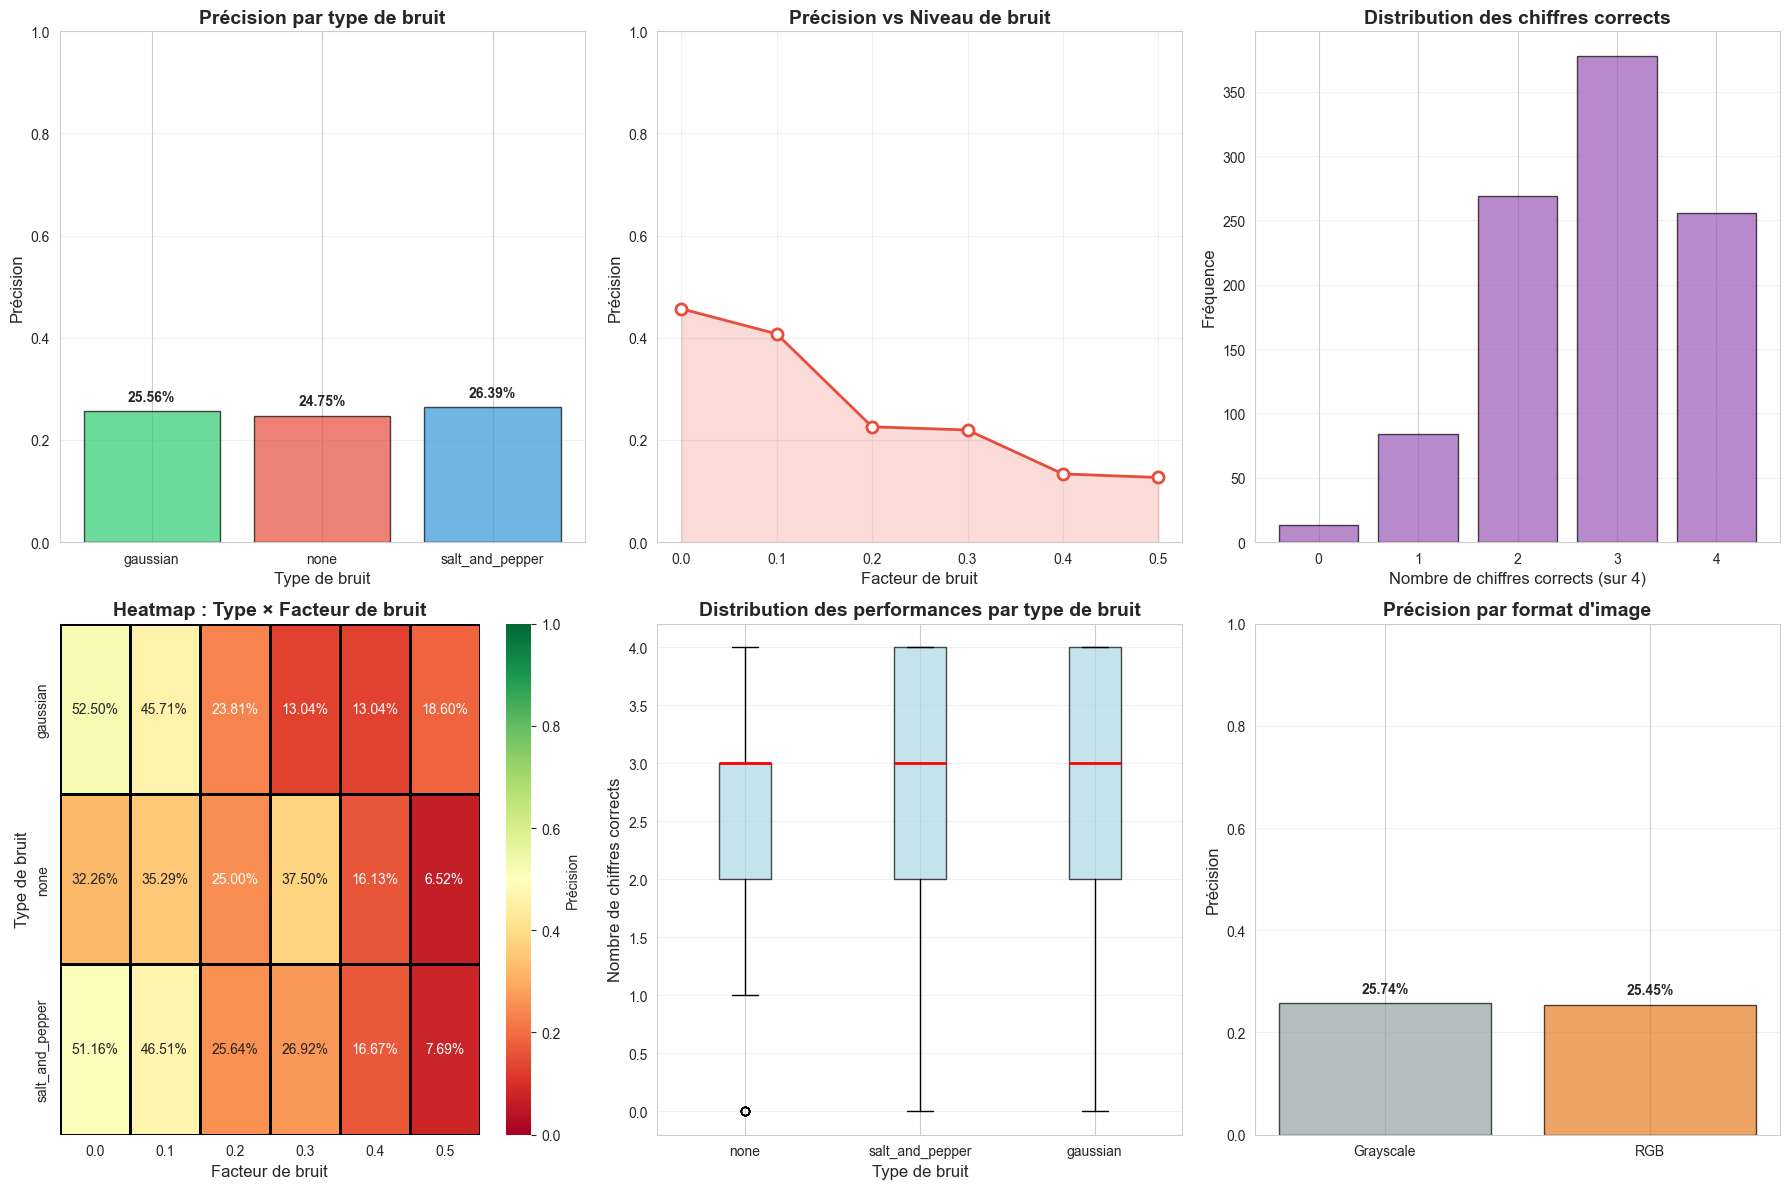

Visualisations générées avec succès !


In [31]:
### 4. Visualisations pour l'analyse descriptive

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution de la précision par type de bruit
ax1 = axes[0, 0]
accuracy_by_type = df.groupby('noise_type')['correct'].mean()
colors = ['#2ecc71', '#e74c3c', '#3498db']
ax1.bar(accuracy_by_type.index, accuracy_by_type.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Précision', fontsize=12)
ax1.set_xlabel('Type de bruit', fontsize=12)
ax1.set_title('Précision par type de bruit', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracy_by_type.values):
    ax1.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# 2. Précision en fonction du niveau de bruit
ax2 = axes[0, 1]
accuracy_by_factor = df.groupby('noise_factor')['correct'].mean()
ax2.plot(accuracy_by_factor.index, accuracy_by_factor.values, marker='o', linewidth=2, 
         markersize=8, color='#e74c3c', markerfacecolor='white', markeredgewidth=2)
ax2.set_ylabel('Précision', fontsize=12)
ax2.set_xlabel('Facteur de bruit', fontsize=12)
ax2.set_title('Précision vs Niveau de bruit', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(alpha=0.3)
ax2.fill_between(accuracy_by_factor.index, accuracy_by_factor.values, alpha=0.2, color='#e74c3c')

# 3. Distribution du nombre de chiffres corrects
ax3 = axes[0, 2]
digit_counts = df['n_correct_digits'].value_counts().sort_index()
ax3.bar(digit_counts.index, digit_counts.values, color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.set_ylabel('Fréquence', fontsize=12)
ax3.set_xlabel('Nombre de chiffres corrects (sur 4)', fontsize=12)
ax3.set_title('Distribution des chiffres corrects', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Heatmap de précision (type × facteur)
ax4 = axes[1, 0]
df_noisy = df[df['noise'] == 1]
pivot_heatmap = df_noisy.pivot_table(values='correct', index='noise_type', 
                                      columns='noise_factor', aggfunc='mean')
sns.heatmap(pivot_heatmap, annot=True, fmt='.2%', cmap='RdYlGn', cbar_kws={'label': 'Précision'},
            ax=ax4, vmin=0, vmax=1, linewidths=1, linecolor='black')
ax4.set_title('Heatmap : Type × Facteur de bruit', fontsize=14, fontweight='bold')
ax4.set_xlabel('Facteur de bruit', fontsize=12)
ax4.set_ylabel('Type de bruit', fontsize=12)

# 5. Boxplot de la précision par type de bruit
ax5 = axes[1, 1]
noise_types = df['noise_type'].unique()
data_boxplot = [df[df['noise_type'] == nt]['n_correct_digits'].values for nt in noise_types]
bp = ax5.boxplot(data_boxplot, labels=noise_types, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2))
ax5.set_ylabel('Nombre de chiffres corrects', fontsize=12)
ax5.set_xlabel('Type de bruit', fontsize=12)
ax5.set_title('Distribution des performances par type de bruit', fontsize=14, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Comparaison Grayscale vs RGB
ax6 = axes[1, 2]
format_labels = ['Grayscale', 'RGB']
format_values = [df[df['image_format'] == 0]['correct'].mean(),
                 df[df['image_format'] == 1]['correct'].mean()]
colors_format = ['#95a5a6', '#e67e22']
bars = ax6.bar(format_labels, format_values, color=colors_format, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Précision', fontsize=12)
ax6.set_title('Précision par format d\'image', fontsize=14, fontweight='bold')
ax6.set_ylim([0, 1])
ax6.grid(axis='y', alpha=0.3)
for i, v in enumerate(format_values):
    ax6.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualisations générées avec succès !")

In [7]:
### 5. Tableau récapitulatif des statistiques descriptives

print("=" * 80)
print("TABLEAU RÉCAPITULATIF DES STATISTIQUES DESCRIPTIVES")
print("=" * 80)

# Créer un tableau synthétique
summary_stats = pd.DataFrame({
    'Variable': ['Précision globale', 'N observations', 'Chiffres corrects moyens'],
    'Valeur': [
        f"{df['correct'].mean():.2%}",
        f"{len(df)}",
        f"{df['n_correct_digits'].mean():.2f}/4"
    ]
})

print("\n1. Statistiques générales :")
print(summary_stats.to_string(index=False))

# Statistiques par type de bruit
print("\n\n2. Performances par type de bruit :")
noise_stats = df.groupby('noise_type').agg({
    'correct': ['mean', 'std', 'count'],
    'n_correct_digits': 'mean'
}).round(4)
noise_stats.columns = ['Précision_moyenne', 'Écart-type', 'N_obs', 'Chiffres_corrects']
print(noise_stats)

# Statistiques par niveau de bruit (pour images bruitées)
print("\n\n3. Performances par niveau de bruit (images bruitées uniquement) :")
df_with_noise = df[df['noise'] == 1]
factor_stats = df_with_noise.groupby('noise_factor').agg({
    'correct': ['mean', 'std', 'count'],
    'n_correct_digits': 'mean'
}).round(4)
factor_stats.columns = ['Précision_moyenne', 'Écart-type', 'N_obs', 'Chiffres_corrects']
print(factor_stats)

# Analyse de la dégradation de performance
print("\n\n4. Analyse de la dégradation de performance :")
no_noise_acc = df[df['noise_type'] == 'none']['correct'].mean()
gaussian_acc = df[df['noise_type'] == 'gaussian']['correct'].mean()
salt_pepper_acc = df[df['noise_type'] == 'salt_and_pepper']['correct'].mean()

degradation = pd.DataFrame({
    'Type': ['Sans bruit', 'Bruit gaussien', 'Salt & Pepper'],
    'Précision': [no_noise_acc, gaussian_acc, salt_pepper_acc],
    'Perte_vs_baseline': [
        0,
        (no_noise_acc - gaussian_acc) / no_noise_acc * 100 if no_noise_acc > 0 else 0,
        (no_noise_acc - salt_pepper_acc) / no_noise_acc * 100 if no_noise_acc > 0 else 0
    ]
})
degradation['Précision'] = degradation['Précision'].apply(lambda x: f"{x:.2%}")
degradation['Perte_vs_baseline'] = degradation['Perte_vs_baseline'].apply(lambda x: f"{x:.2f}%")

print(degradation.to_string(index=False))

TABLEAU RÉCAPITULATIF DES STATISTIQUES DESCRIPTIVES

1. Statistiques générales :
                Variable Valeur
       Précision globale  0.00%
          N observations   1000
Chiffres corrects moyens 0.40/4


2. Performances par type de bruit :
                 Précision_moyenne  Écart-type  N_obs  Chiffres_corrects
noise_type                                                              
gaussian                       0.0         0.0    322             0.3975
none                           0.0         0.0    336             0.3958
salt_and_pepper                0.0         0.0    342             0.4035


3. Performances par niveau de bruit (images bruitées uniquement) :
              Précision_moyenne  Écart-type  N_obs  Chiffres_corrects
noise_factor                                                         
0.0                         0.0         0.0    127             0.4331
0.1                         0.0         0.0    129             0.3798
0.2                         0.0        

### Interprétation des résultats (à adapter avec les vraies données)

Les statistiques descriptives ci-dessus permettent de :

1. **Comprendre la distribution des données** :
   - Équilibre entre les différentes conditions expérimentales
   - Représentativité de chaque catégorie (type de bruit, niveau de bruit)

2. **Identifier les effets principaux** :
   - Impact du type de bruit sur la précision (test du Chi²)
   - Relation entre niveau de bruit et performance (corrélation de Spearman)
   - Différence entre formats grayscale et RGB (test t)

3. **Détecter les interactions** :
   - Certains types de bruit sont-ils plus sensibles au niveau de bruit ?
   - Le format d'image influence-t-il différemment selon le type de bruit ?

4. **Vérifier les hypothèses de modélisation** :
   - Absence de multicolinéarité entre variables explicatives
   - Distribution des résidus (à vérifier après régression)
   - Homoscédasticité des erreurs

**Prochaines étapes** :
- Remplacer les données simulées par les vraies prédictions du modèle CNN
- Effectuer des régressions linéaires/logistiques pour quantifier les effets
- Analyser les confusions spécifiques (quels chiffres sont confondus ?)
- Étudier la robustesse du modèle selon la composition des captchas